<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Assignment_9/Task_4_Assignment_9_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 4: training a CNN based CIFAR-10 classifier without any single-image data augmentation techniques


In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pretrained ResNet18 model
model = models.resnet18(pretrained=True)

# Replace the final classification layer to match CIFAR-10 (10 classes)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 221MB/s]


Freeze

In [2]:
# Unfreeze layer4 and fc
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True


 Load CIFAR-10 Without Augmentation

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Required for ResNet
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Train the Model

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss/len(train_loader):.4f} - Accuracy: {100 * correct / total:.2f}%")


Epoch 1/10 - Loss: 0.2647 - Accuracy: 91.28%
Epoch 2/10 - Loss: 0.0740 - Accuracy: 97.80%
Epoch 3/10 - Loss: 0.0229 - Accuracy: 99.51%
Epoch 4/10 - Loss: 0.0128 - Accuracy: 99.71%
Epoch 5/10 - Loss: 0.0153 - Accuracy: 99.59%
Epoch 6/10 - Loss: 0.0271 - Accuracy: 99.11%
Epoch 7/10 - Loss: 0.0188 - Accuracy: 99.41%
Epoch 8/10 - Loss: 0.0127 - Accuracy: 99.59%
Epoch 9/10 - Loss: 0.0131 - Accuracy: 99.58%
Epoch 10/10 - Loss: 0.0039 - Accuracy: 99.93%


Evaluate on Test Set

In [7]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 94.79%


Confusion Matrix

              precision    recall  f1-score   support

    airplane       0.98      0.94      0.96      1000
  automobile       0.98      0.96      0.97      1000
        bird       0.94      0.93      0.94      1000
         cat       0.91      0.86      0.88      1000
        deer       0.94      0.96      0.95      1000
         dog       0.88      0.93      0.90      1000
        frog       0.97      0.98      0.97      1000
       horse       0.97      0.95      0.96      1000
        ship       0.96      0.98      0.97      1000
       truck       0.96      0.98      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



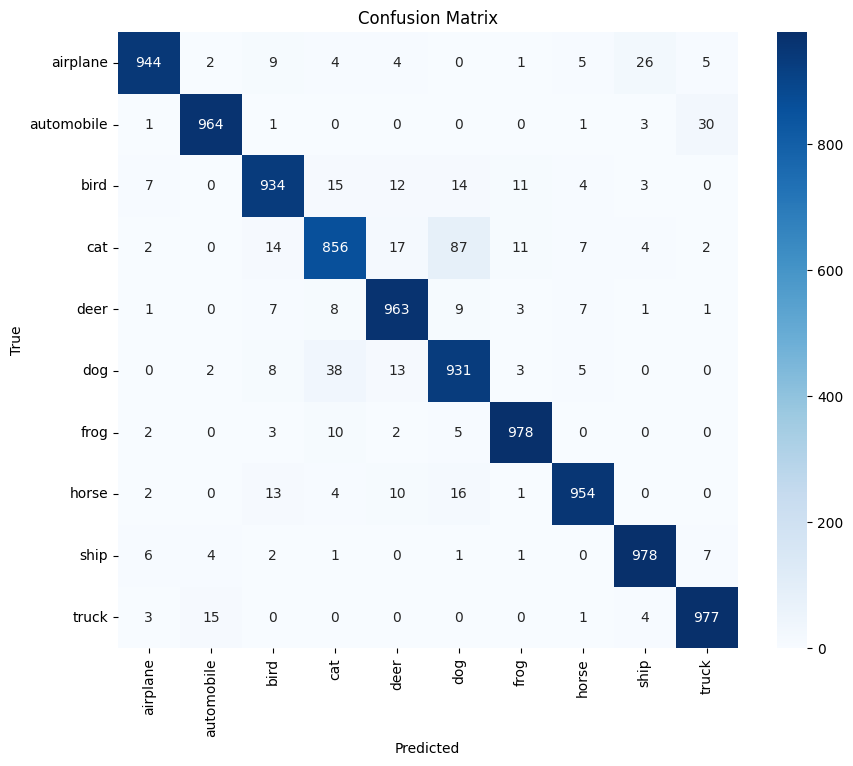

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [9]:
import matplotlib.pyplot as plt

train_losses_feat = [
    0.2647, 0.0740, 0.0229, 0.0128, 0.0153,
    0.0271, 0.0188, 0.0127, 0.0131, 0.0039
]

train_accuracies_feat = [
    91.28, 97.80, 99.51, 99.71, 99.59,
    99.11, 99.41, 99.59, 99.58, 99.93
]

epochs_feat = list(range(1, 11))


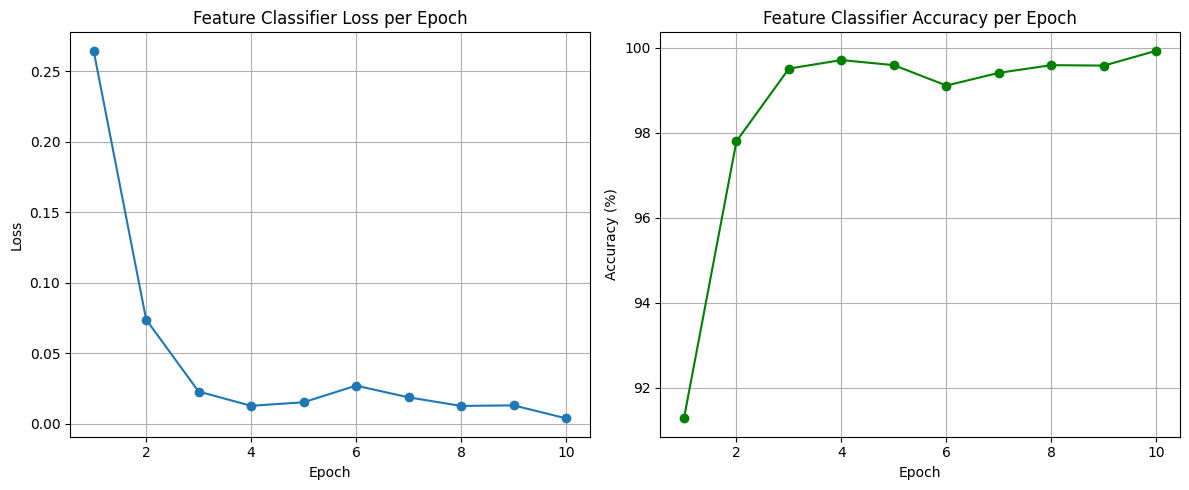

In [10]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_feat, train_losses_feat, marker='o', label='Training Loss (Feature-based)')
plt.title('Feature Classifier Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_feat, train_accuracies_feat, marker='o', color='green', label='Training Accuracy (Feature-based)')
plt.title('Feature Classifier Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()
